# What makes a popular story popular?

In [2]:
from urllib.request import urlopen, Request
import json
import datetime
import csv
import time

In [3]:
app_id = " "
app_secret = " " 
page_id = "13652355666"

In [4]:
access_token = app_id + "|" + app_secret

In [5]:
def request_until_succeed(url):
    req = Request(url)
    success = False
    while success is False:
        try:
            response = urlopen(req)
            if response.getcode() == 200:
                success = True
        except Exception as e:
            print(e)
            time.sleep(5)
            print("Error for URL {}: {}".format(url, datetime.datetime.now()))
            print("Retrying.")
    return response.read()

In [6]:
def unicode_decode(text):
    try:
        return text.encode('utf-8').decode()
    except UnicodeDecodeError:
        return text.encode('utf-8')

In [7]:
def getFacebookPageFeedUrl(base_url):
    fields = "&fields=message,link,created_time,type,name,id," + \
        "comments.limit(0).summary(true),shares,reactions" + \
        ".limit(0).summary(true)"
    return base_url + fields

In [8]:
# "reactions" are the new label for what used to be "likes"
# we want a breakdown of reactions for further insights into user engagement
def getReactionsForStatuses(base_url):
    reaction_types = ['like', 'love', 'wow', 'haha', 'sad', 'angry']
    reactions_dict = {} 
    for reaction_type in reaction_types:
        fields = "&fields=reactions.type({}).limit(0).summary(total_count)".format(
            reaction_type.upper())
        url = base_url + fields
        data = json.loads(request_until_succeed(url))['data']
        data_processed = set()  
        for status in data:
            id = status['id']
            count = status['reactions']['summary']['total_count']
            data_processed.add((id, count))
        for id, count in data_processed:
            if id in reactions_dict:
                reactions_dict[id] = reactions_dict[id] + (count,)
            else:
                reactions_dict[id] = (count,)
    return reactions_dict

In [9]:
# These will be most of the columns for our dataframe (Reactions broken out in different function)
def processFacebookPageFeedStatus(status):
    status_id = status['id']
    status_type = status['type']
    status_message = '' if 'message' not in status else \
        unicode_decode(status['message'])
    link_name = '' if 'name' not in status else \
        unicode_decode(status['name'])
    status_link = '' if 'link' not in status else \
        unicode_decode(status['link'])
    status_published = datetime.datetime.strptime(
        status['created_time'], '%Y-%m-%dT%H:%M:%S+0000')
    status_published = status_published + \
        datetime.timedelta(hours=-5)  # EST
    status_published = status_published.strftime(
        '%Y-%m-%d %H:%M:%S')
    num_reactions = 0 if 'reactions' not in status else \
        status['reactions']['summary']['total_count']
    num_comments = 0 if 'comments' not in status else \
        status['comments']['summary']['total_count']
    num_shares = 0 if 'shares' not in status else status['shares']['count']
    return (status_id, status_message, link_name, status_type, status_link,
            status_published, num_reactions, num_comments, num_shares)

In [10]:
# dump the csv in the working directory or S3
# currently set to dump in working directory
def scrapeFacebookPageFeedStatus(page_id, access_token):
    with open('{}_facebook_statuses.csv'.format(page_id), 'w') as file:
        w = csv.writer(file)
        w.writerow(["status_id", "status_message", "link_name", "status_type",
                    "status_link", "status_published", "num_reactions",
                    "num_comments", "num_shares", "num_likes", "num_loves",
                    "num_wows", "num_hahas", "num_sads", "num_angrys"])
        has_next_page = True
        num_processed = 0
        scrape_starttime = datetime.datetime.now()
        after = ''
        base = "https://graph.facebook.com/v2.9"
        node = "/{}/posts".format(page_id)
        parameters = "/?limit={}&access_token={}".format(100, access_token)
        print("Scraping {} Facebook Page: {}\n".format(page_id, scrape_starttime))
        while has_next_page:
            after = '' if after is '' else "&after={}".format(after)
            base_url = base + node + parameters + after
            url = getFacebookPageFeedUrl(base_url)
            statuses = json.loads(request_until_succeed(url))
            reactions = getReactionsForStatuses(base_url)
            for status in statuses['data']:
                if 'reactions' in status:
                    status_data = processFacebookPageFeedStatus(status)
                    reactions_data = reactions[status_data[0]]
                    w.writerow(status_data + reactions_data)
                num_processed += 1
                if num_processed % 100 == 0:
                    print("{} Statuses Processed: {}".format
                          (num_processed, datetime.datetime.now()))
            if 'paging' in statuses:
                after = statuses['paging']['cursors']['after']
            else:
                has_next_page = False
        print("\nDone!\n{} Statuses Processed in {}".format(
              num_processed, datetime.datetime.now() - scrape_starttime))

In [11]:
if __name__ == '__main__':
    scrapeFacebookPageFeedStatus(page_id, access_token)

Scraping 13652355666 Facebook Page: 2017-06-03 12:31:57.983815

100 Statuses Processed: 2017-06-03 12:32:02.579359
200 Statuses Processed: 2017-06-03 12:32:06.365146
300 Statuses Processed: 2017-06-03 12:32:09.948173
400 Statuses Processed: 2017-06-03 12:32:13.941844
500 Statuses Processed: 2017-06-03 12:32:18.243594
600 Statuses Processed: 2017-06-03 12:32:23.159678
700 Statuses Processed: 2017-06-03 12:32:29.098485
800 Statuses Processed: 2017-06-03 12:32:35.040136
900 Statuses Processed: 2017-06-03 12:32:41.692332
1000 Statuses Processed: 2017-06-03 12:32:46.739204
1100 Statuses Processed: 2017-06-03 12:32:51.934947
1200 Statuses Processed: 2017-06-03 12:32:57.055356
1300 Statuses Processed: 2017-06-03 12:33:03.004736
1400 Statuses Processed: 2017-06-03 12:33:08.726661
1500 Statuses Processed: 2017-06-03 12:33:14.257428
1600 Statuses Processed: 2017-06-03 12:33:20.506372
1700 Statuses Processed: 2017-06-03 12:33:26.339556
1800 Statuses Processed: 2017-06-03 12:33:32.178436
1900 Stat

KeyboardInterrupt: 

In [24]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv("13652355666_facebook_statuses.csv")

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 15 columns):
status_id           18000 non-null object
status_message      17568 non-null object
link_name           17646 non-null object
status_type         18000 non-null object
status_link         17990 non-null object
status_published    18000 non-null object
num_reactions       18000 non-null int64
num_comments        18000 non-null int64
num_shares          18000 non-null int64
num_likes           18000 non-null int64
num_loves           18000 non-null int64
num_wows            18000 non-null int64
num_hahas           18000 non-null int64
num_sads            18000 non-null int64
num_angrys          18000 non-null int64
dtypes: int64(9), object(6)
memory usage: 2.1+ MB


In [27]:
df.head()

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,num_total_engagement
0,13652355666_10154891119265667,"Michael Bloomberg and other ""partners"" pledged...",Bloomberg pledges $15M for Paris climate agree...,link,https://www.usatoday.com/story/news/nation-now...,2017-06-03 11:15:00,464,13,22,414,36,5,6,0,3,499
1,13652355666_10154888171715667,"""It takes a woman so much to admit something l...",Emily Doe's letter to Brock Turner: 1 year lat...,link,https://www.usatoday.com/story/news/2017/06/02...,2017-06-03 11:01:00,364,5,9,349,3,4,1,6,1,378
2,13652355666_10155445794200530,"Guys, if you don't want to spend the summer al...","Want a date, guys? Ditch these fashion fails",video,https://www.facebook.com/usatoday/videos/10155...,2017-06-03 10:29:00,557,14,10,536,4,2,13,0,2,581
3,13652355666_10154890752870667,"Though he was a titan of the surfing world, O'...","Surfing icon Jack O'Neill, wetsuit pioneer, di...",link,https://www.usatoday.com/story/news/2017/06/03...,2017-06-03 10:10:00,1081,22,68,964,13,24,1,79,0,1171
4,13652355666_10154890740675667,You shouldn't leave one in for longer than 8-1...,"Toxic shock syndrome, infections: What if I le...",link,https://www.usatoday.com/story/news/nation-now...,2017-06-03 09:35:00,991,31,28,957,12,18,3,1,0,1050


In [15]:
df.describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000
mean,7126.422778,290.271889,329.002500,6605.372111,243.081167,83.612889,84.600056,54.095278,55.157444
std,5488.123707,677.337243,6461.103579,4526.811485,895.210219,156.377961,243.161976,354.212266,266.165202
min,364.000000,0.000000,0.000000,310.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3949.000000,91.000000,21.000000,3703.000000,75.000000,26.000000,21.000000,5.000000,4.000000
50%,6744.000000,195.000000,46.000000,6316.000000,176.000000,53.000000,43.000000,10.000000,10.000000
75%,9126.250000,349.000000,133.000000,8494.000000,303.000000,100.000000,82.000000,21.000000,24.000000
max,402846.000000,54666.000000,632891.000000,309635.000000,68788.000000,5691.000000,13316.000000,30926.000000,12803.000000


In [16]:
# Most reactions
df.query("num_reactions == 402846")

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
16057,13652355666_1221892954513018,It was her first day back at school after her ...,Police officers are there for family of falle...,video,https://www.facebook.com/usatoday/videos/12218...,2016-10-29 23:43:00,402846,13582,632891,309635,60320,1604,248,30926,118


In [17]:
# Most comments
df.query("num_comments == 54666")

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
5435,13652355666_10158378823240632,This nugget ice maker will take your Sonic Dri...,Opal's Nugget Ice Machine lets you make Sonic ...,video,https://www.facebook.com/usatoday/videos/10158...,2017-03-28 10:00:00,56232,54666,306453,46302,7226,2462,207,19,15


In [19]:
# Most shares
df.query("num_shares == 632891")

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
16057,13652355666_1221892954513018,It was her first day back at school after her ...,Police officers are there for family of falle...,video,https://www.facebook.com/usatoday/videos/12218...,2016-10-29 23:43:00,402846,13582,632891,309635,60320,1604,248,30926,118


In [20]:
# create a new feature to see the total engagement on a post
df['num_total_engagement'] = df['num_reactions'] + df['num_shares'] + df["num_comments"] 

In [21]:
df.describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,num_total_engagement
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04
mean,7126.422778,290.271889,329.002500,6605.372111,243.081167,83.612889,84.600056,54.095278,55.157444,7.745697e+03
std,5488.123707,677.337243,6461.103579,4526.811485,895.210219,156.377961,243.161976,354.212266,266.165202,1.128822e+04
min,364.000000,0.000000,0.000000,310.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.780000e+02
25%,3949.000000,91.000000,21.000000,3703.000000,75.000000,26.000000,21.000000,5.000000,4.000000,4.276750e+03
50%,6744.000000,195.000000,46.000000,6316.000000,176.000000,53.000000,43.000000,10.000000,10.000000,7.127000e+03
75%,9126.250000,349.000000,133.000000,8494.000000,303.000000,100.000000,82.000000,21.000000,24.000000,9.638250e+03
max,402846.000000,54666.000000,632891.000000,309635.000000,68788.000000,5691.000000,13316.000000,30926.000000,12803.000000,1.049319e+06


In [22]:
# Most shares
df.query("num_total_engagement == 1.049319e+06")

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,num_total_engagement
16057,13652355666_1221892954513018,It was her first day back at school after her ...,Police officers are there for family of falle...,video,https://www.facebook.com/usatoday/videos/12218...,2016-10-29 23:43:00,402846,13582,632891,309635,60320,1604,248,30926,118,1049319


link      14089
video      3113
photo       786
status       10
event         2
Name: status_type, dtype: int64


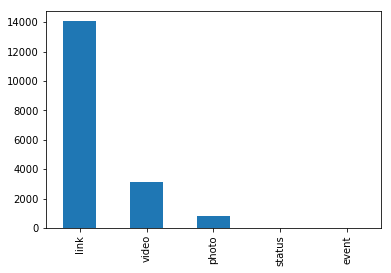

In [26]:
df['status_type'].value_counts().plot(kind='bar')
print(df['status_type'].value_counts())

In [28]:
df_status = pd.get_dummies(df['status_type'])

In [29]:
df_status.head()

,event,link,photo,status,video
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0


In [31]:
df1 = pd.concat([df,df_status], axis=1)

In [32]:
df1.head()

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,...,num_wows,num_hahas,num_sads,num_angrys,num_total_engagement,event,link,photo,status,video
0,13652355666_10154891119265667,"Michael Bloomberg and other ""partners"" pledged...",Bloomberg pledges $15M for Paris climate agree...,link,https://www.usatoday.com/story/news/nation-now...,2017-06-03 11:15:00,464,13,22,414,...,5,6,0,3,499,0,1,0,0,0
1,13652355666_10154888171715667,"""It takes a woman so much to admit something l...",Emily Doe's letter to Brock Turner: 1 year lat...,link,https://www.usatoday.com/story/news/2017/06/02...,2017-06-03 11:01:00,364,5,9,349,...,4,1,6,1,378,0,1,0,0,0
2,13652355666_10155445794200530,"Guys, if you don't want to spend the summer al...","Want a date, guys? Ditch these fashion fails",video,https://www.facebook.com/usatoday/videos/10155...,2017-06-03 10:29:00,557,14,10,536,...,2,13,0,2,581,0,0,0,0,1
3,13652355666_10154890752870667,"Though he was a titan of the surfing world, O'...","Surfing icon Jack O'Neill, wetsuit pioneer, di...",link,https://www.usatoday.com/story/news/2017/06/03...,2017-06-03 10:10:00,1081,22,68,964,...,24,1,79,0,1171,0,1,0,0,0
4,13652355666_10154890740675667,You shouldn't leave one in for longer than 8-1...,"Toxic shock syndrome, infections: What if I le...",link,https://www.usatoday.com/story/news/nation-now...,2017-06-03 09:35:00,991,31,28,957,...,18,3,1,0,1050,0,1,0,0,0


In [34]:
# Be advised that not all variables are independent
# reactions are the total of likes, loves, wows, hahas, sads, and angrys
# total engagement is the total of reactions, comments, and shares
df1.corr()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,num_total_engagement,event,link,photo,status,video
num_reactions,1.000000,0.456826,0.653725,0.985980,0.767912,0.472743,0.251465,0.459884,0.143327,0.887769,-0.009144,0.007890,0.004266,-0.000634,-0.010614
num_comments,0.456826,1.000000,0.610341,0.393423,0.537567,0.372734,0.247195,0.175894,0.240638,0.631448,0.000206,-0.074535,-0.034892,0.002678,0.099955
num_shares,0.653725,0.610341,1.000000,0.581624,0.750659,0.329835,0.126844,0.518592,0.060826,0.926828,-0.000537,-0.042786,-0.004827,-0.001005,0.049340
num_likes,0.985980,0.393423,0.581624,1.000000,0.681905,0.427288,0.212881,0.382780,0.071440,0.835879,-0.010032,0.024602,0.007805,-0.000032,-0.030762
num_loves,0.767912,0.537567,0.750659,0.681905,1.000000,0.354159,0.132093,0.374507,0.032890,0.835260,-0.002409,-0.070934,0.006381,-0.000516,0.073998
num_wows,0.472743,0.372734,0.329835,0.427288,0.354159,1.000000,0.159922,0.184646,0.310614,0.440994,-0.004861,-0.026066,-0.007501,-0.003651,0.032839
num_hahas,0.251465,0.247195,0.126844,0.212881,0.132093,0.159922,1.000000,0.006931,0.103693,0.209693,-0.003017,0.006634,-0.023229,-0.002259,0.005543
num_sads,0.459884,0.175894,0.518592,0.382780,0.374507,0.184646,0.006931,1.000000,0.265131,0.530971,-0.001595,-0.004600,-0.012597,-0.002070,0.011995
num_angrys,0.143327,0.240638,0.060826,0.071440,0.032890,0.310614,0.103693,0.265131,1.000000,0.118938,-0.002066,-0.001446,-0.024160,-0.003770,0.014924
num_total_engagement,0.887769,0.631448,0.926828,0.835879,0.835260,0.440994,0.209693,0.530971,0.118938,1.000000,-0.004741,-0.025126,-0.002783,-0.000723,0.029078


In [39]:
correlated_with_shares = df1.corr()['num_shares'].sort_values()

In [40]:
# videos barely have a statistically significant correlation with sharing
# love reactions and comments have a strong correlation to sharing
correlated_with_shares

link                   -0.042786
photo                  -0.004827
status                 -0.001005
event                  -0.000537
video                   0.049340
num_angrys              0.060826
num_hahas               0.126844
num_wows                0.329835
num_sads                0.518592
num_likes               0.581624
num_comments            0.610341
num_reactions           0.653725
num_loves               0.750659
num_total_engagement    0.926828
num_shares              1.000000
Name: num_shares, dtype: float64

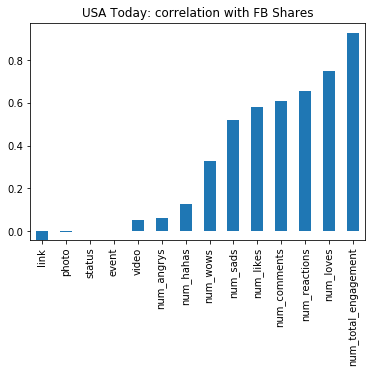

In [46]:
correlated_with_shares.iloc[:-1].plot(kind='bar',
                                        title='USA Today: correlation with FB Shares')

In [41]:
correlated_with_reactions = df1.corr()['num_reactions'].sort_values()

In [42]:
# type of post (video, photo, status, etc.) does not have a statistically significant correlation with FB reactions
# Sharing is more closely correlated with reactions than commenting
correlated_with_reactions

video                  -0.010614
event                  -0.009144
status                 -0.000634
photo                   0.004266
link                    0.007890
num_angrys              0.143327
num_hahas               0.251465
num_comments            0.456826
num_sads                0.459884
num_wows                0.472743
num_shares              0.653725
num_loves               0.767912
num_total_engagement    0.887769
num_likes               0.985980
num_reactions           1.000000
Name: num_reactions, dtype: float64

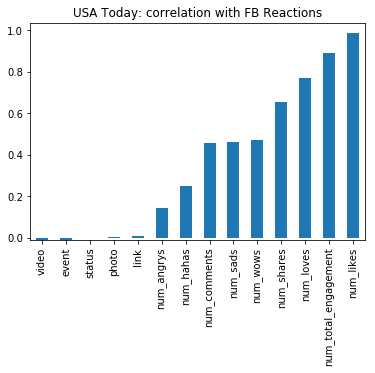

In [47]:
correlated_with_reactions.iloc[:-1].plot(kind='bar',
                                        title='USA Today: correlation with FB Reactions')

In [43]:
correlated_with_comments = df1.corr()['num_comments'].sort_values()

In [44]:
# links as posts appear to have a small negative correlation to FB comments
# videos have a minor correlation to commenting
# love reactions and shares have a moderate to strong correlation to commenting
correlated_with_comments

link                   -0.074535
photo                  -0.034892
event                   0.000206
status                  0.002678
video                   0.099955
num_sads                0.175894
num_angrys              0.240638
num_hahas               0.247195
num_wows                0.372734
num_likes               0.393423
num_reactions           0.456826
num_loves               0.537567
num_shares              0.610341
num_total_engagement    0.631448
num_comments            1.000000
Name: num_comments, dtype: float64

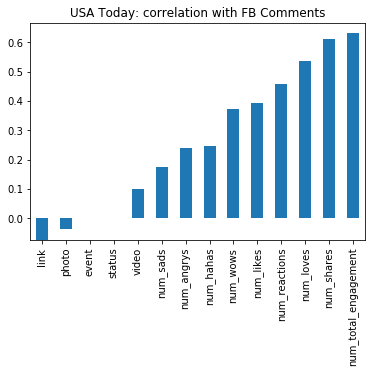

In [48]:
correlated_with_comments.iloc[:-1].plot(kind='bar',
                                        title='USA Today: correlation with FB Comments')

In [45]:
df1['num_total_engagement'].describe()

count    1.800000e+04
mean     7.745697e+03
std      1.128822e+04
min      3.780000e+02
25%      4.276750e+03
50%      7.127000e+03
75%      9.638250e+03
max      1.049319e+06
Name: num_total_engagement, dtype: float64

## breakdown by hour

In [50]:
df1.tail()

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,...,num_wows,num_hahas,num_sads,num_angrys,num_total_engagement,event,link,photo,status,video
17995,13652355666_1713130429011478,Kim Kardashian West's alleged assailants are s...,Kim Kardashian West robbed at gunpoint,video,https://www.facebook.com/usatoday/videos/17131...,2016-10-03 14:05:49,2425,477,62,2245,...,33,100,12,9,2964,0,0,0,0,1
17996,13652355666_10153899320125667,Bet you know someone who could use this.,This wearable helps reduce anxiety,link,http://wearables.reviewed.com/features/this-we...,2016-10-03 13:53:33,2588,173,25,2544,...,2,10,3,1,2786,0,1,0,0,0
17997,13652355666_10153899243170667,NaN,USA TODAY Life,video,https://www.facebook.com/USATODAYlife/videos/1...,2016-10-03 13:12:41,2401,202,0,2344,...,5,15,0,0,2603,0,0,0,0,1
17998,13652355666_10153898851315667,"""Life sucks in bear country.""",Man survives 2 bear attacks in same morning,link,http://www.usatoday.com/story/news/2016/10/03/...,2016-10-03 12:44:00,3432,279,219,3237,...,146,6,5,3,3930,0,1,0,0,0
17999,13652355666_10153899149990667,BREAKING: The New York attorney general's offi...,New York AG orders Trump Foundation to stop so...,link,http://www.usatoday.com/story/news/politics/el...,2016-10-03 12:32:42,4224,622,482,3751,...,52,274,5,40,5328,0,1,0,0,0


In [65]:
df1['datetime'] = pd.to_datetime(df1['status_published'])

In [66]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 22 columns):
status_id               18000 non-null object
status_message          17568 non-null object
link_name               17646 non-null object
status_type             18000 non-null object
status_link             17990 non-null object
status_published        18000 non-null object
num_reactions           18000 non-null int64
num_comments            18000 non-null int64
num_shares              18000 non-null int64
num_likes               18000 non-null int64
num_loves               18000 non-null int64
num_wows                18000 non-null int64
num_hahas               18000 non-null int64
num_sads                18000 non-null int64
num_angrys              18000 non-null int64
num_total_engagement    18000 non-null int64
event                   18000 non-null uint8
link                    18000 non-null uint8
photo                   18000 non-null uint8
status                  18000 

In [68]:
hours = df1['datetime'].dt.hour

In [69]:
df1['hours'] = hours

In [70]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 23 columns):
status_id               18000 non-null object
status_message          17568 non-null object
link_name               17646 non-null object
status_type             18000 non-null object
status_link             17990 non-null object
status_published        18000 non-null object
num_reactions           18000 non-null int64
num_comments            18000 non-null int64
num_shares              18000 non-null int64
num_likes               18000 non-null int64
num_loves               18000 non-null int64
num_wows                18000 non-null int64
num_hahas               18000 non-null int64
num_sads                18000 non-null int64
num_angrys              18000 non-null int64
num_total_engagement    18000 non-null int64
event                   18000 non-null uint8
link                    18000 non-null uint8
photo                   18000 non-null uint8
status                  18000 

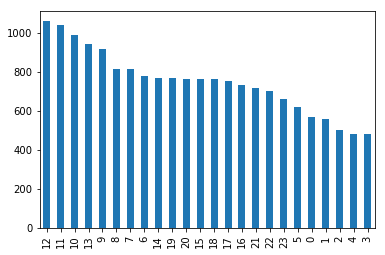

In [73]:
df1['hours'].value_counts().plot(kind='bar')

[-1, 24, 0, 100000]

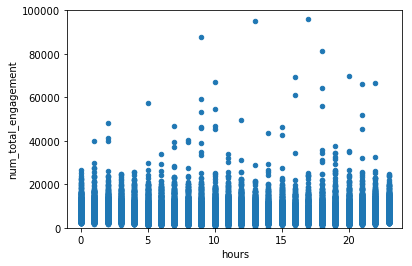

In [111]:
# breaking news can occur at any time as seem by the popular outliers
df1.plot(kind='scatter', x='hours', y='num_total_engagement')
plt.axis([-1, 24, 0, 100000])

[-1, 24, 0, 100000]

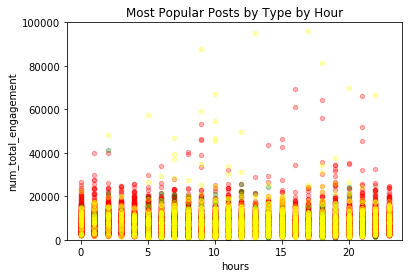

In [124]:
# note that the Facebook API is giving us when something was posted, not when it was engaged with by users
event = df1[df1['event'] == 1]
link = df1[df1['link'] == 1]
photo = df1[df1['photo'] == 1]
status = df1[df1['status'] == 1]
video = df1[df1['video'] == 1]
fig, ax = plt.subplots()

event.plot(kind='scatter', x='hours', y='num_total_engagement',
           ax=ax, color='blue', alpha=0.3,
           title='Most Popular Posts by Type by Hour')

link.plot(kind='scatter', x='hours', y='num_total_engagement',
             ax=ax, color='red', alpha=0.3)

photo.plot(kind='scatter', x='hours', y='num_total_engagement',
             ax=ax, color='green', alpha=0.3)

status.plot(kind='scatter', x='hours', y='num_total_engagement',
             ax=ax, color='black', alpha=0.3)
video.plot(kind='scatter', x='hours', y='num_total_engagement',
             ax=ax, color='yellow', alpha=0.3)
plt.axis([-1, 24, 0, 100000])

In [140]:
correlated_with_hour = df1.corr()['hours'].sort_values()

In [141]:
# Note "hour" is when a post goes public so we see there are some weak negative correlations to engagement
correlated_with_hour

num_likes              -0.076079
num_reactions          -0.062168
link                   -0.059276
num_comments           -0.043797
num_total_engagement   -0.029613
num_wows               -0.017998
num_loves              -0.012007
event                   0.000828
photo                   0.005554
num_shares              0.005660
num_hahas               0.005989
status                  0.007734
num_sads                0.019466
num_angrys              0.031770
video                   0.061130
hours                   1.000000
Name: hours, dtype: float64

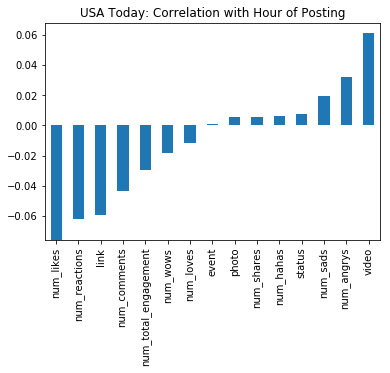

In [143]:
correlated_with_hour.iloc[:-1].plot(kind='bar',
                                        title='USA Today: Correlation with Hour of Posting')

In [144]:
correlated_with_total_engagement = df1.corr()['num_total_engagement'].sort_values()

In [145]:
# note that most of the features below are subsets of total engagement
# of note, there are no statistically significant correlations to the type of content and total engagement
correlated_with_total_engagement

hours                  -0.029613
link                   -0.025126
event                  -0.004741
photo                  -0.002783
status                 -0.000723
video                   0.029078
num_angrys              0.118938
num_hahas               0.209693
num_wows                0.440994
num_sads                0.530971
num_comments            0.631448
num_loves               0.835260
num_likes               0.835879
num_reactions           0.887769
num_shares              0.926828
num_total_engagement    1.000000
Name: num_total_engagement, dtype: float64

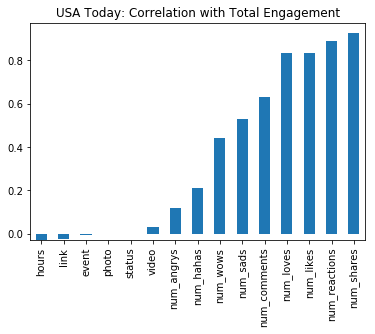

In [147]:
correlated_with_total_engagement.iloc[:-1].plot(kind='bar',
                                        title='USA Today: Correlation with Total Engagement')

In [149]:
df1['num_total_engagement'].describe()

count    1.800000e+04
mean     7.745697e+03
std      1.128822e+04
min      3.780000e+02
25%      4.276750e+03
50%      7.127000e+03
75%      9.638250e+03
max      1.049319e+06
Name: num_total_engagement, dtype: float64

In [150]:
# let's split off the most popular content defined by the most engaged
top75_df = df1[df1['num_total_engagement'] > 9.638250e+03]

In [151]:
top75_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 40 to 17945
Data columns (total 23 columns):
status_id               4500 non-null object
status_message          4457 non-null object
link_name               4360 non-null object
status_type             4500 non-null object
status_link             4495 non-null object
status_published        4500 non-null object
num_reactions           4500 non-null int64
num_comments            4500 non-null int64
num_shares              4500 non-null int64
num_likes               4500 non-null int64
num_loves               4500 non-null int64
num_wows                4500 non-null int64
num_hahas               4500 non-null int64
num_sads                4500 non-null int64
num_angrys              4500 non-null int64
num_total_engagement    4500 non-null int64
event                   4500 non-null uint8
link                    4500 non-null uint8
photo                   4500 non-null uint8
status                  4500 non-null uint8
video

In [200]:
pd.set_option('max_colwidth',1000)

In [201]:
top75_df.head()

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,...,num_sads,num_angrys,num_total_engagement,event,link,photo,status,video,datetime,hours
40,13652355666_1880520502272469,"In an emotional statement, comedian Kathy Griffin says she's not afraid of Donald Trump. https://usat.ly/2rkPh8h",Kathy Griffin: Trump's trying to ruin my life forever,video,https://www.facebook.com/usatoday/videos/1880520502272469/,2017-06-02 16:27:01,6828,2656,515,4975,...,36,320,9999,0,0,0,0,1,2017-06-02 16:27:01,16
146,13652355666_10154882742015667,"The new signatories plan to use their wealth to support causes focused on poverty alleviation, education, healthcare research, climate change and the environment.","14 billionaires join Bill Gates, Warren Buffett in giving away more than half their money",link,https://usat.ly/2rg9QCD,2017-06-01 17:20:00,16088,317,4084,13158,...,7,6,20489,0,1,0,0,0,2017-06-01 17:20:00,17
165,13652355666_10154882525200667,"""I believe that there is a creator in God who is much bigger than us. And I’m confident that, if there’s a real problem, he can take care of it.”",GOP congressman on climate change: God will 'take care of it' if it's real,link,https://usat.ly/2qFZ6id,2017-06-01 13:06:29,5501,1632,6668,2595,...,149,1303,13801,0,1,0,0,0,2017-06-01 13:06:29,13
275,13652355666_10154877763120667,"BREAKING: A day after Kathy Griffin released a photo holding a mock ""decapitated"" head of President Trump, CNN has announced that they have terminated their contract with her.",CNN fires Kathy Griffin over offensive Trump photo,link,https://www.usatoday.com/story/life/people/2017/05/31/cnn-fires-kathy-griffin-over-offensive-trump-photo/102349176/,2017-05-31 12:43:55,8021,956,886,6652,...,85,128,9863,0,1,0,0,0,2017-05-31 12:43:55,12
434,13652355666_10154870292835667,"You can plant herbs and flowers that repel those bugs, including mosquitoes, and add a touch of beauty to your backyard.",9 plants that bug bugs — including mosquitoes,link,https://www.usatoday.com/story/news/nation-now/2016/06/04/bug-mosquito-repellent-plants/85400368/,2017-05-30 05:29:00,10739,288,10052,10111,...,3,0,21079,0,1,0,0,0,2017-05-30 05:29:00,5


link      3619
video      698
photo      178
status       5
Name: status_type, dtype: int64


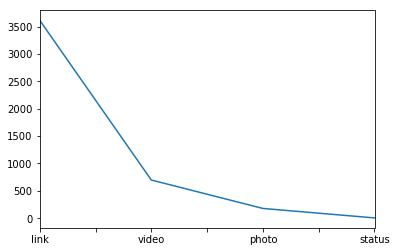

In [264]:
top75_df['status_type'].value_counts().plot()
print(top75_df['status_type'].value_counts())

In [265]:
top75_df.describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,num_total_engagement,event,link,photo,status,video,hours
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4.500000e+03,4500.0,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,12464.549111,510.529778,1019.739778,11337.096667,532.630000,173.025778,174.989778,119.900000,126.714000,1.399482e+04,0.0,0.804222,0.039556,0.001111,0.155111,11.087111
std,8191.066721,1281.332237,12894.552966,6204.480458,1748.175755,277.525155,450.198445,677.983448,498.889503,2.100038e+04,0.0,0.396842,0.194934,0.033319,0.362051,7.064398
min,3826.000000,5.000000,0.000000,2595.000000,30.000000,17.000000,5.000000,0.000000,0.000000,9.639000e+03,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10006.250000,167.000000,36.000000,9273.000000,309.000000,78.000000,52.000000,12.000000,12.000000,1.060500e+04,0.0,1.000000,0.000000,0.000000,0.000000,5.000000
50%,11206.500000,299.000000,95.000000,10378.500000,382.000000,120.000000,81.000000,19.000000,19.000000,1.191100e+04,0.0,1.000000,0.000000,0.000000,0.000000,11.000000
75%,13294.000000,522.000000,409.250000,12258.000000,479.000000,179.000000,143.000000,37.000000,44.250000,1.429725e+04,0.0,1.000000,0.000000,0.000000,0.000000,17.250000
max,402846.000000,54666.000000,632891.000000,309635.000000,68788.000000,5691.000000,13316.000000,30926.000000,12803.000000,1.049319e+06,0.0,1.000000,1.000000,1.000000,1.000000,23.000000


In [267]:
top75_df.sort_values(by='num_total_engagement', ascending=False)

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,...,num_sads,num_angrys,num_total_engagement,event,link,photo,status,video,datetime,hours
16057,13652355666_1221892954513018,It was her first day back at school after her father was killed in the line of duty. Look who showed up.,Police officers are there for family of fallen comrade,video,https://www.facebook.com/usatoday/videos/1221892954513018/,2016-10-29 23:43:00,402846,13582,632891,309635,...,30926,118,1049319,0,0,0,0,1,2016-10-29 23:43:00,23
10981,13652355666_1299565206745792,"A pregnant goat from West Virginia had an unexpected birthing coach show up days before delivery: Pretty Boy, a male cat.",Cat helps pregnant goat through contractions,video,https://www.facebook.com/usatoday/videos/1299565206745792/,2017-01-13 00:00:00,149573,26156,354148,110016,...,34,23,529877,0,0,0,0,1,2017-01-13 00:00:00,0
5802,13652355666_1832107287113791,"When this baby wouldn't stop crying, Dad handed him a shirt from Mom's laundry basket. The 3-month-old instantly calmed down after recognizing her smell.",All this baby needs is his mom's dirty laundry,video,https://www.facebook.com/usatoday/videos/1832107287113791/,2017-03-23 07:13:02,218248,29096,268228,142434,...,415,27,515572,0,0,0,0,1,2017-03-23 07:13:02,7
5435,13652355666_10158378823240632,This nugget ice maker will take your Sonic Drive-In ice obsession to a whole new level: http://rvwd.co/2myb8bb,Opal's Nugget Ice Machine lets you make Sonic ice at home,video,https://www.facebook.com/usatoday/videos/10158378823240632/,2017-03-28 10:00:00,56232,54666,306453,46302,...,19,15,417351,0,0,0,0,1,2017-03-28 10:00:00,10
9014,13652355666_1323822830986696,When you and your best friend know you look good. (Tag your bestie!),These pigs have some serious swagger,video,https://www.facebook.com/usatoday/videos/1323822830986696/,2017-02-08 23:00:00,40177,13889,155236,29395,...,12,26,209302,0,0,0,0,1,2017-02-08 23:00:00,23
3524,13652355666_1399864796715832,This is what true love looks like.,Baby won't take eyes off mom for even a second,video,https://www.facebook.com/usatoday/videos/1399864796715832/,2017-04-20 06:11:39,111437,11812,78217,69907,...,28,8,201466,0,0,0,0,1,2017-04-20 06:11:39,6
2175,13652355666_1418749674827344,"On his 10th birthday, Kalani only asked for one thing: For his stepdad to adopt him.",10-year-old reads heartfelt letter asking his stepdad to adopt...,video,https://www.facebook.com/usatoday/videos/1418749674827344/,2017-05-09 06:20:00,113385,4298,40939,71595,...,2563,5,158622,0,0,0,0,1,2017-05-09 06:20:00,6
496,13652355666_10154857265030667,"On Memorial Day, we remember.",Memorial Day: Remembering lives lost in war,video,https://www.facebook.com/usatoday/videos/10154857265030667/,2017-05-29 05:53:00,21625,295,86907,16520,...,3411,15,108827,0,0,0,0,1,2017-05-29 05:53:00,5
2566,13652355666_1413137998721845,"This puppy was nervous before surgery, so her (dreamy) vet decided to sing a song to her.",Dreamy vet sings to nervous puppy before surgery,video,https://www.facebook.com/usatoday/videos/1413137998721845/,2017-05-03 17:20:00,62897,6006,26920,44425,...,109,6,95823,0,0,0,0,1,2017-05-03 17:20:00,17
1627,13652355666_1425598917475753,"This ASL interpreter does more than just sign words. At rap concerts for legends like Snoop Dogg and Wu-Tang Clan, she went so hard, she stole the show. https://usat.ly/2pPpSPW",Sign language interpreter steals show at Snoop concert,video,https://www.facebook.com/usatoday/videos/1425598917475753/,2017-05-15 13:40:00,69526,5363,20024,55917,...,7,17,94913,0,0,0,0,1,2017-05-15 13:40:00,13


In [269]:
top75_df['status_type'].value_counts()

link      3619
video      698
photo      178
status       5
Name: status_type, dtype: int64

In [281]:
print("On average, videos are the most engaged content")
print(" ")
video = top75_df.loc[top75_df['status_type'] == 'video', 'num_total_engagement'].mean()
print("Avg. number of videos: %i" % (video))

link = top75_df.loc[top75_df['status_type'] == 'link', 'num_total_engagement'].mean()
print("Avg. number of links: %i" % (link))

photo = top75_df.loc[top75_df['status_type'] == 'photo', 'num_total_engagement'].mean()
print("Avg. number of photos: %i" % (photo))

status = top75_df.loc[top75_df['status_type'] == 'status', 'num_total_engagement'].mean()
print("Avg. number of statuses: %i" % (status))

On average, videos are the most engaged content
 
Avg. number of videos: 18679
Avg. number of links: 13138
Avg. number of photos: 13145
Avg. number of statuses: 10312


### Recommendation:
#### Follow up analysis on word frequency with status_message & link_name x total engagement